In [10]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
# import utils.mpl_pubstyle  # noqa: F401

In [11]:
# NvsNt1 --> Nh=100 (tested too many Nts and Ns, see comment in next cell)
# NvsNt2 --> Nh=200
# NvsNt3 --> Nh=50
# NvsNt4 --> Nh=150

Nh = 100
problem_name = 'AdvDiff2D'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
path = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name, 'NvsNt1')
# path = "/home/riccardo/Desktop/PhD/MyRepos/FD-PyIMEX-RB/__RESULTS/AdvDiff2D/NvsNt1"
results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)

In [12]:
Nt_FE = results['Nt_FE'][None][0][0]

Ns = results['N_values'][None][0][:-1]  # --> comment the last slice for tests different than the first
Nts = results['Nt_values'][None][0][2:-1]

errIMEX = results['errors_l2'][None][0]['IMEX-RB'][2:-1, :-1]
errBE = results['errors_l2'][None][0]['BE'][2:-1]

timesIMEX = results['times'][None][0]['IMEX-RB'][2:-1, :-1]
timesBE = results['times'][None][0]['BE'][2:-1]

subiters = results['subiters'][None][0]['IMEX-RB'][2:-1, :-1]
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

/tmp/ipykernel_19954/2693956344.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


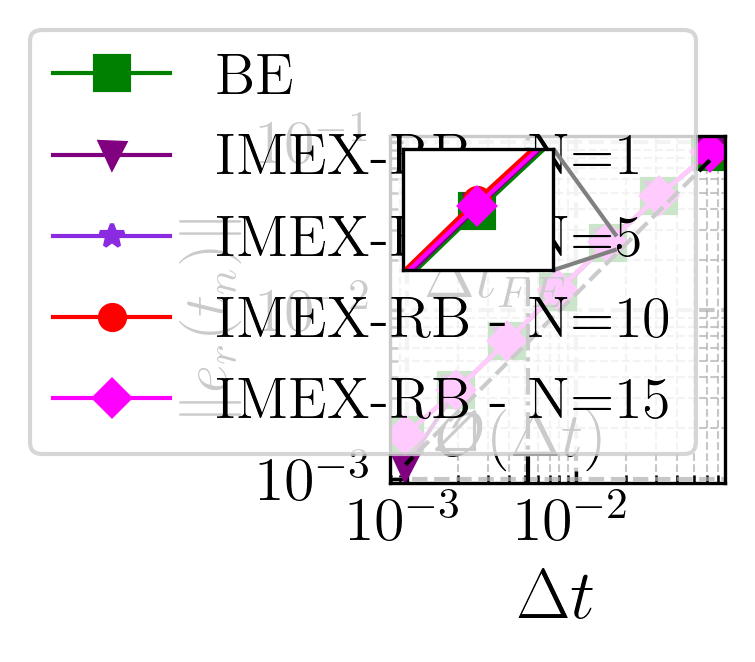

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(1 / Nts, errBE, '-s', markersize=8, color="green", label="BE")
ax.loglog(1 / Nts, errIMEX[:, 0], '-v', markersize=6, color="purple", 
           label=f"IMEX-RB - N={Ns[0]}")
ax.loglog(1 / Nts, errIMEX[:, 1], '-*', markersize=6, color="blueviolet", 
           label=f"IMEX-RB - N={Ns[1]}")
ax.loglog(1 / Nts, errIMEX[:, 2], '-o', markersize=6, color="red", 
           label=f"IMEX-RB - N={Ns[2]}")
ax.loglog(1 / Nts, errIMEX[:, 3], '-D', markersize=6, color="magenta", 
           label=f"IMEX-RB - N={Ns[3]}")
#ax.loglog(1 / Nts, errIMEX[:, 4], '-X', markersize=6, color="hotpink", 
#           label=f"IMEX-RB - N={Ns[4]}")

ax.loglog(1 / Nts, (Nts[0] * errBE[0] * 0.9) / Nts, 
          color="k", linestyle='--', linewidth=1)

x0, y0 = 0.0015, 0.0015
dx = 0.001
dy = dx  # for slope 1: dy = dx
ax.plot([x0, x0+dx], [y0, y0], 'k-', linewidth=.75)        
ax.plot([x0+dx, x0+dx], [y0, y0+dy], 'k-', linewidth=.75)        
ax.plot([x0+dx, x0], [y0+dy, y0], 'k-', linewidth=.75)     
ax.text(x0, y0-dy/2.5, r"$\mathcal{O}(\Delta t)$", fontsize=15, ha='left', va='bottom')

ax.axvline(1 / Nt_FE, color="k", linestyle='-.') 
ax.text(1.3e-3, 1.2e-2, r"$\Delta t_{FE}$", fontsize=15, color='k')

ax.set_aspect('equal')

# Create an inset axis inside the main axis
axins = inset_axes(ax, width="45%", height="35%", loc='upper left')
axins.loglog(1 / Nts, errBE, '-s', markersize=8, color="green", label="BE")

axins.loglog(1 / Nts, errIMEX[:, 0], '-v', markersize=6, color="purple", 
             label=f"IMEX-RB - N={Ns[0]}")
axins.loglog(1 / Nts, errIMEX[:, 1], '-*', markersize=6, color="blueviolet", 
             label=f"IMEX-RB - N={Ns[1]}")
axins.loglog(1 / Nts, errIMEX[:, 2], '-o', markersize=6, color="red", 
             label=f"IMEX-RB - N={Ns[2]}")
axins.loglog(1 / Nts, errIMEX[:, 3], '-D', markersize=6, color="magenta", 
             label=f"IMEX-RB - N={Ns[3]}")
#axins.loglog(1 / Nts, errIMEX[:, 4], '-X', markersize=6, color="hotpink", 
#             label=f"IMEX-RB - N={Ns[4]}")

# Set the zoomed-in region limits
axins.set_xlim(1.4e-2, 1.75e-2)
axins.set_ylim(2.3e-2, 2.75e-2)

# Optional: remove tick labels for inset
# Turn off ticks and numbers cleanly
axins.tick_params(
    axis='both',        # both axes
    which='both',       # both major and minor ticks
    bottom=False,       # no bottom ticks
    top=False,          # no top ticks
    left=False,         # no left ticks
    right=False,        # no right ticks
    labelbottom=False,  # no x-axis labels
    labelleft=False     # no y-axis labels
)

# Draw lines connecting the inset region to the main plot
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")

ax.grid(which="major", linewidth=1, linestyle='--')
ax.grid(which="minor", linewidth=0.5, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=14, loc="lower right")

ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Relative error", fontsize=15)

plt.tight_layout()

plt.savefig(f'errors_N_Nh_{Nh}.png', dpi=400)

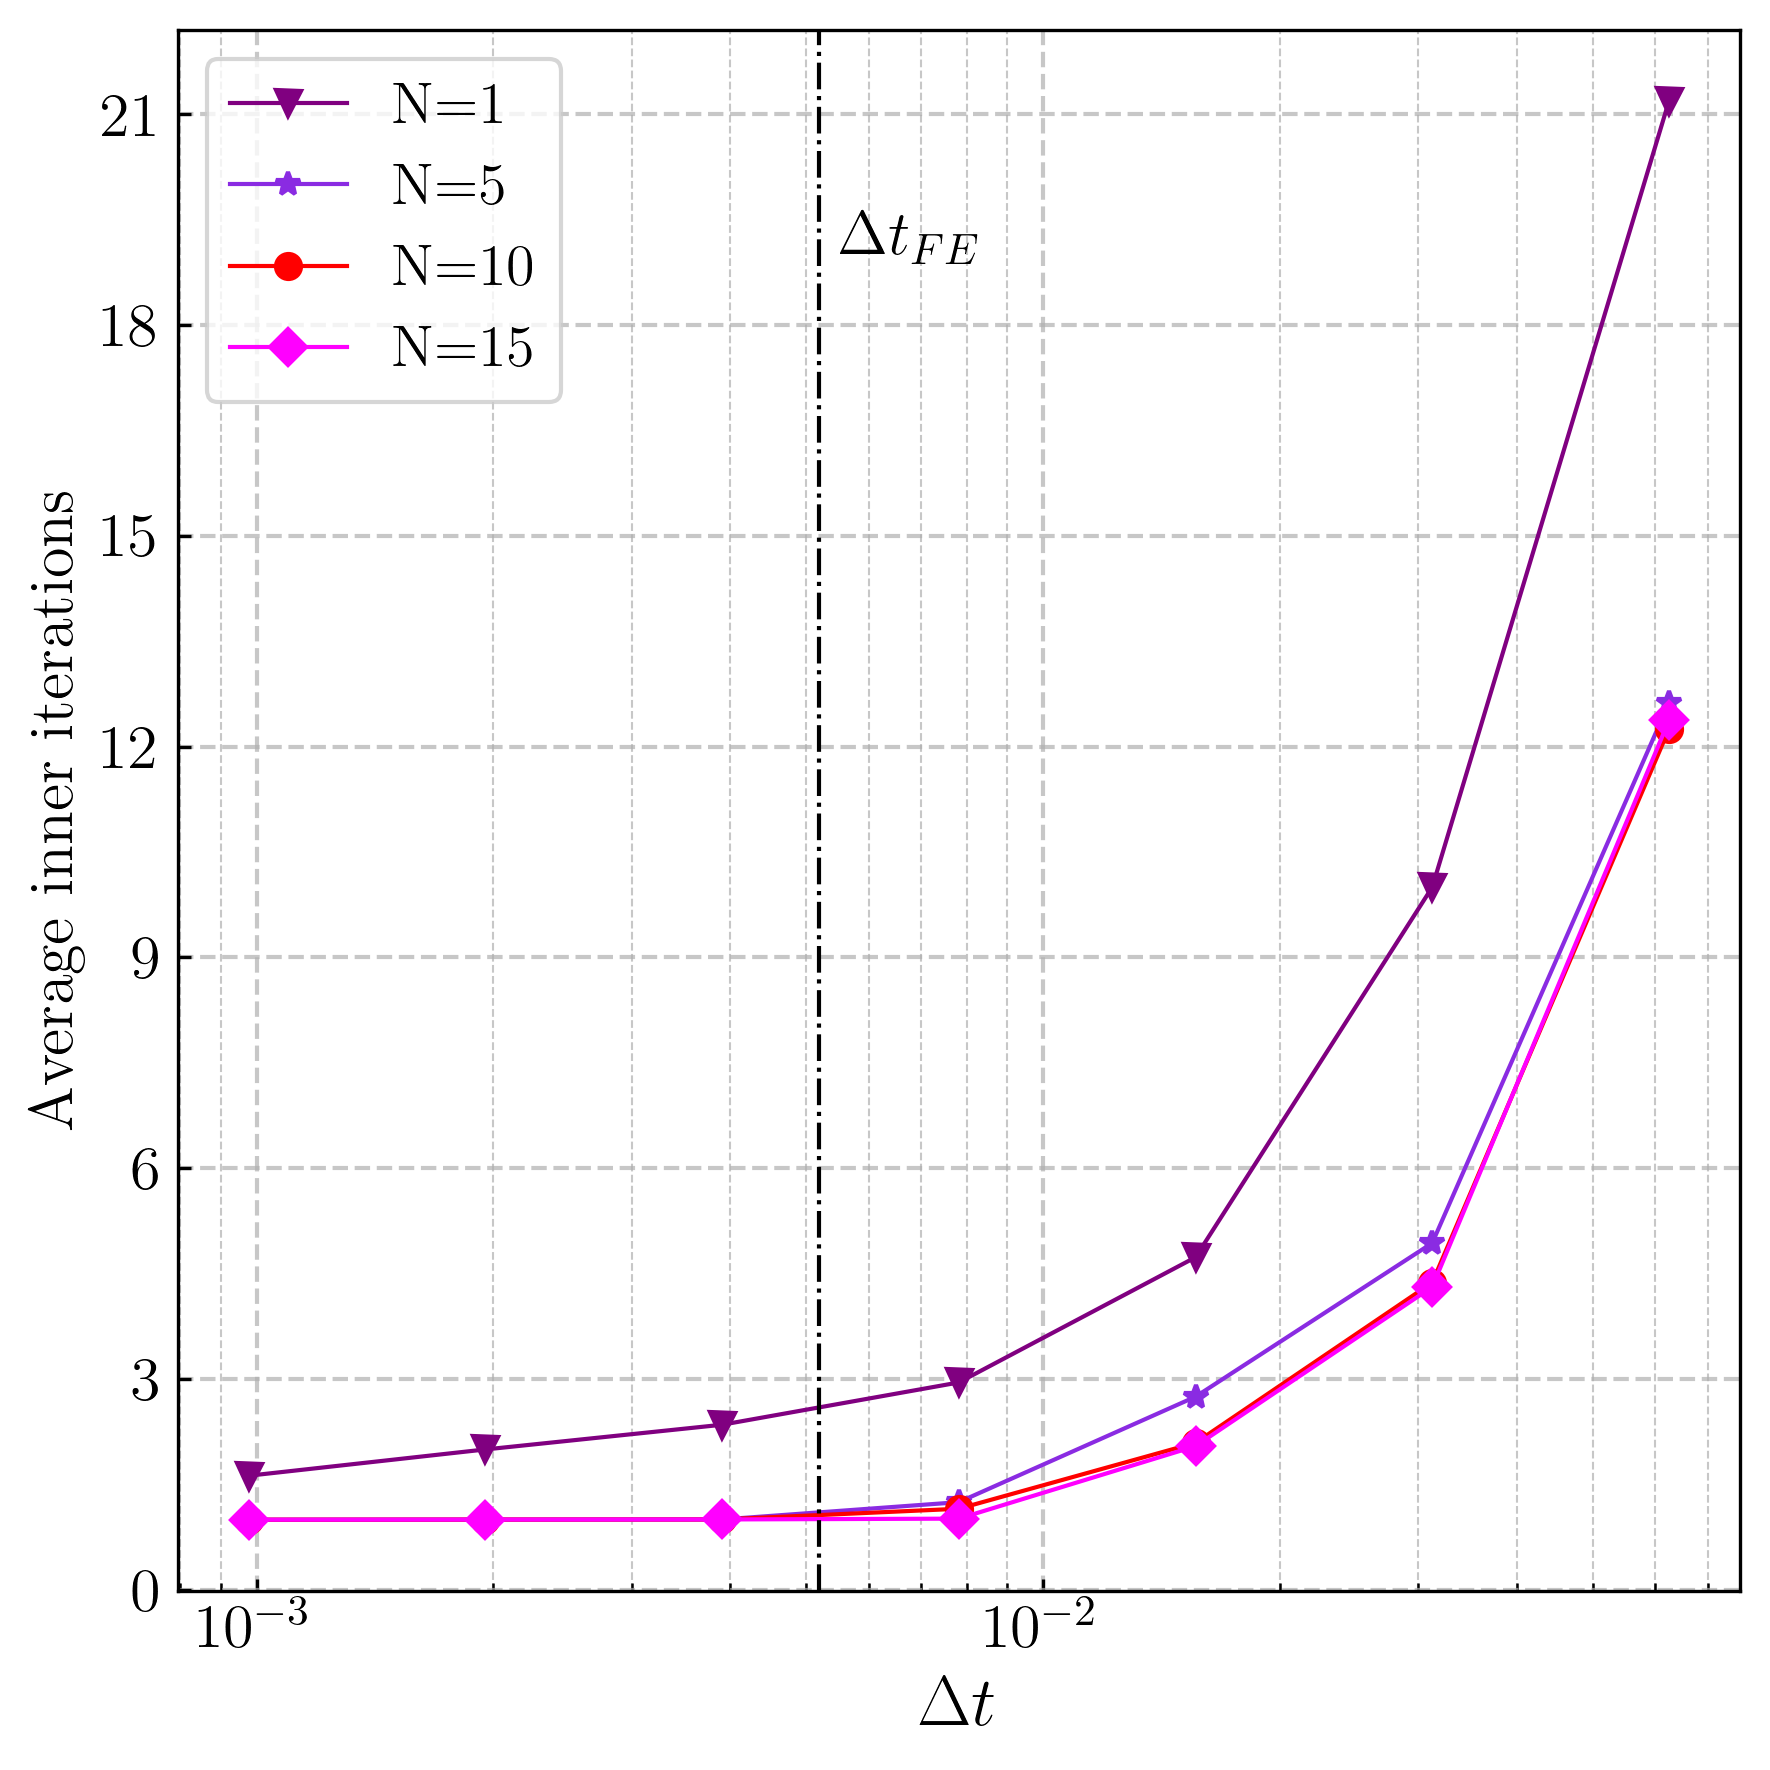

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
ax.semilogx(1 / Nts, np.mean(masked_subiters[:, 0] + 1, axis=-1), '-v', markersize=6, color="purple", 
           label=f"N={Ns[0]}")
ax.semilogx(1 / Nts, np.mean(masked_subiters[:, 1] + 1, axis=-1), '-*', markersize=6, color="blueviolet", 
           label=f"N={Ns[1]}")
ax.semilogx(1 / Nts, np.mean(masked_subiters[:, 2] + 1, axis=-1), '-o', markersize=6, color="red", 
           label=f"N={Ns[2]}")
ax.semilogx(1 / Nts, np.mean(masked_subiters[:, 3] + 1, axis=-1), '-D', markersize=6, color="magenta", 
           label=f"N={Ns[3]}")
#ax.semilogx(1 / Nts, np.mean(masked_subiters[:, 4] + 1, axis=-1), '-X', markersize=6, color="red", 
#           label=f"N={Ns[4]}")

ax.axvline(1 / Nt_FE, color="k", linestyle='-.') 
ax.text(5.5e-3, 19, r"$\Delta t_{FE}$", fontsize=15, color='k')

ax.legend(fontsize=14, loc="upper left")
ax.grid(which="major", linestyle='--', linewidth=1)
ax.grid(axis="x", which="minor", linestyle='--', linewidth=.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Average inner iterations", fontsize=15)

# plt.tight_layout()

plt.savefig(f'subiters_N_Nh_{Nh}.png', dpi=400)

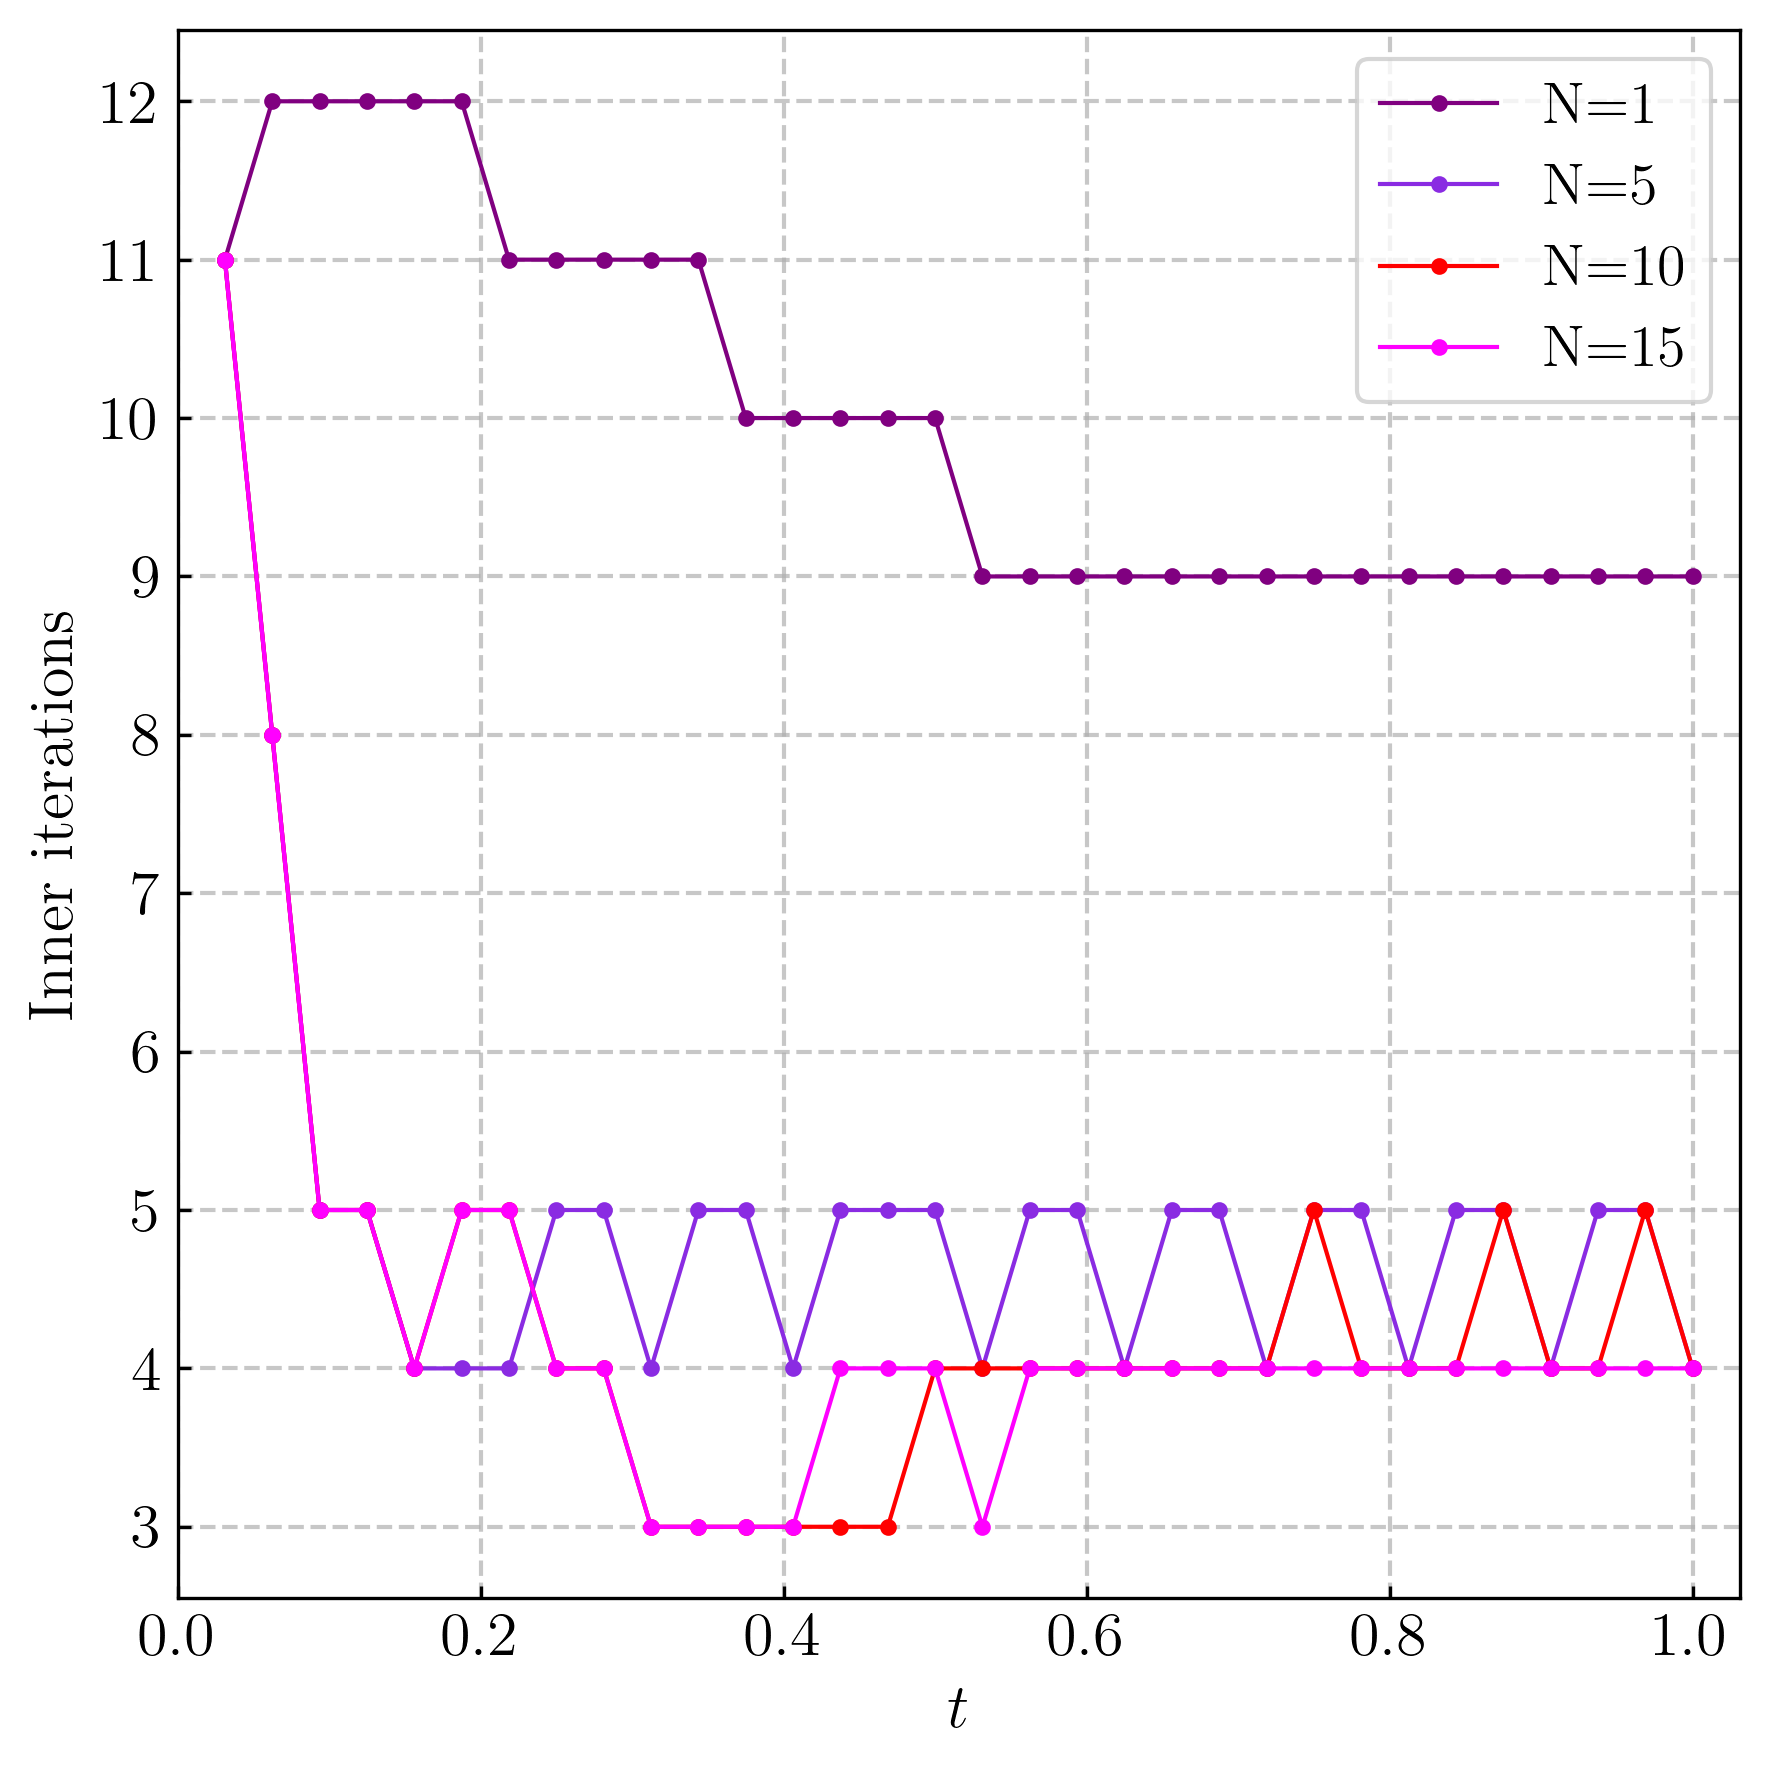

In [6]:
Nt_idx = 1
tvec = np.linspace(0,1, Nts[Nt_idx]+1)[1:]

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(tvec, subiters[Nt_idx, 0, :Nts[Nt_idx]] + 1, '-o', markersize=3, color="purple", 
           label=f"N={Ns[0]}")
ax.plot(tvec, subiters[Nt_idx, 1, :Nts[Nt_idx]] + 1, '-o', markersize=3, color="blueviolet", 
           label=f"N={Ns[1]}")
ax.plot(tvec, subiters[Nt_idx, 2, :Nts[Nt_idx]] + 1, '-o', markersize=3, color="red", 
           label=f"N={Ns[2]}")
ax.plot(tvec, subiters[Nt_idx, 3, :Nts[Nt_idx]] + 1, '-o', markersize=3, color="magenta", 
           label=f"N={Ns[3]}")
#ax.plot(tvec, subiters[Nt_idx, 4, :Nts[Nt_idx]] + 1, '-o', markersize=3, color="red", 
#           label=f"N={Ns[4]}")

ax.legend(fontsize=14)
ax.grid(which="major", linestyle='--', linewidth=1)

ax.set_xlim([0, 1+1/Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel("Inner iterations", fontsize=15)

# plt.tight_layout()

plt.savefig(f'subiters_time_N_Nh_{Nh}.png', dpi=400)

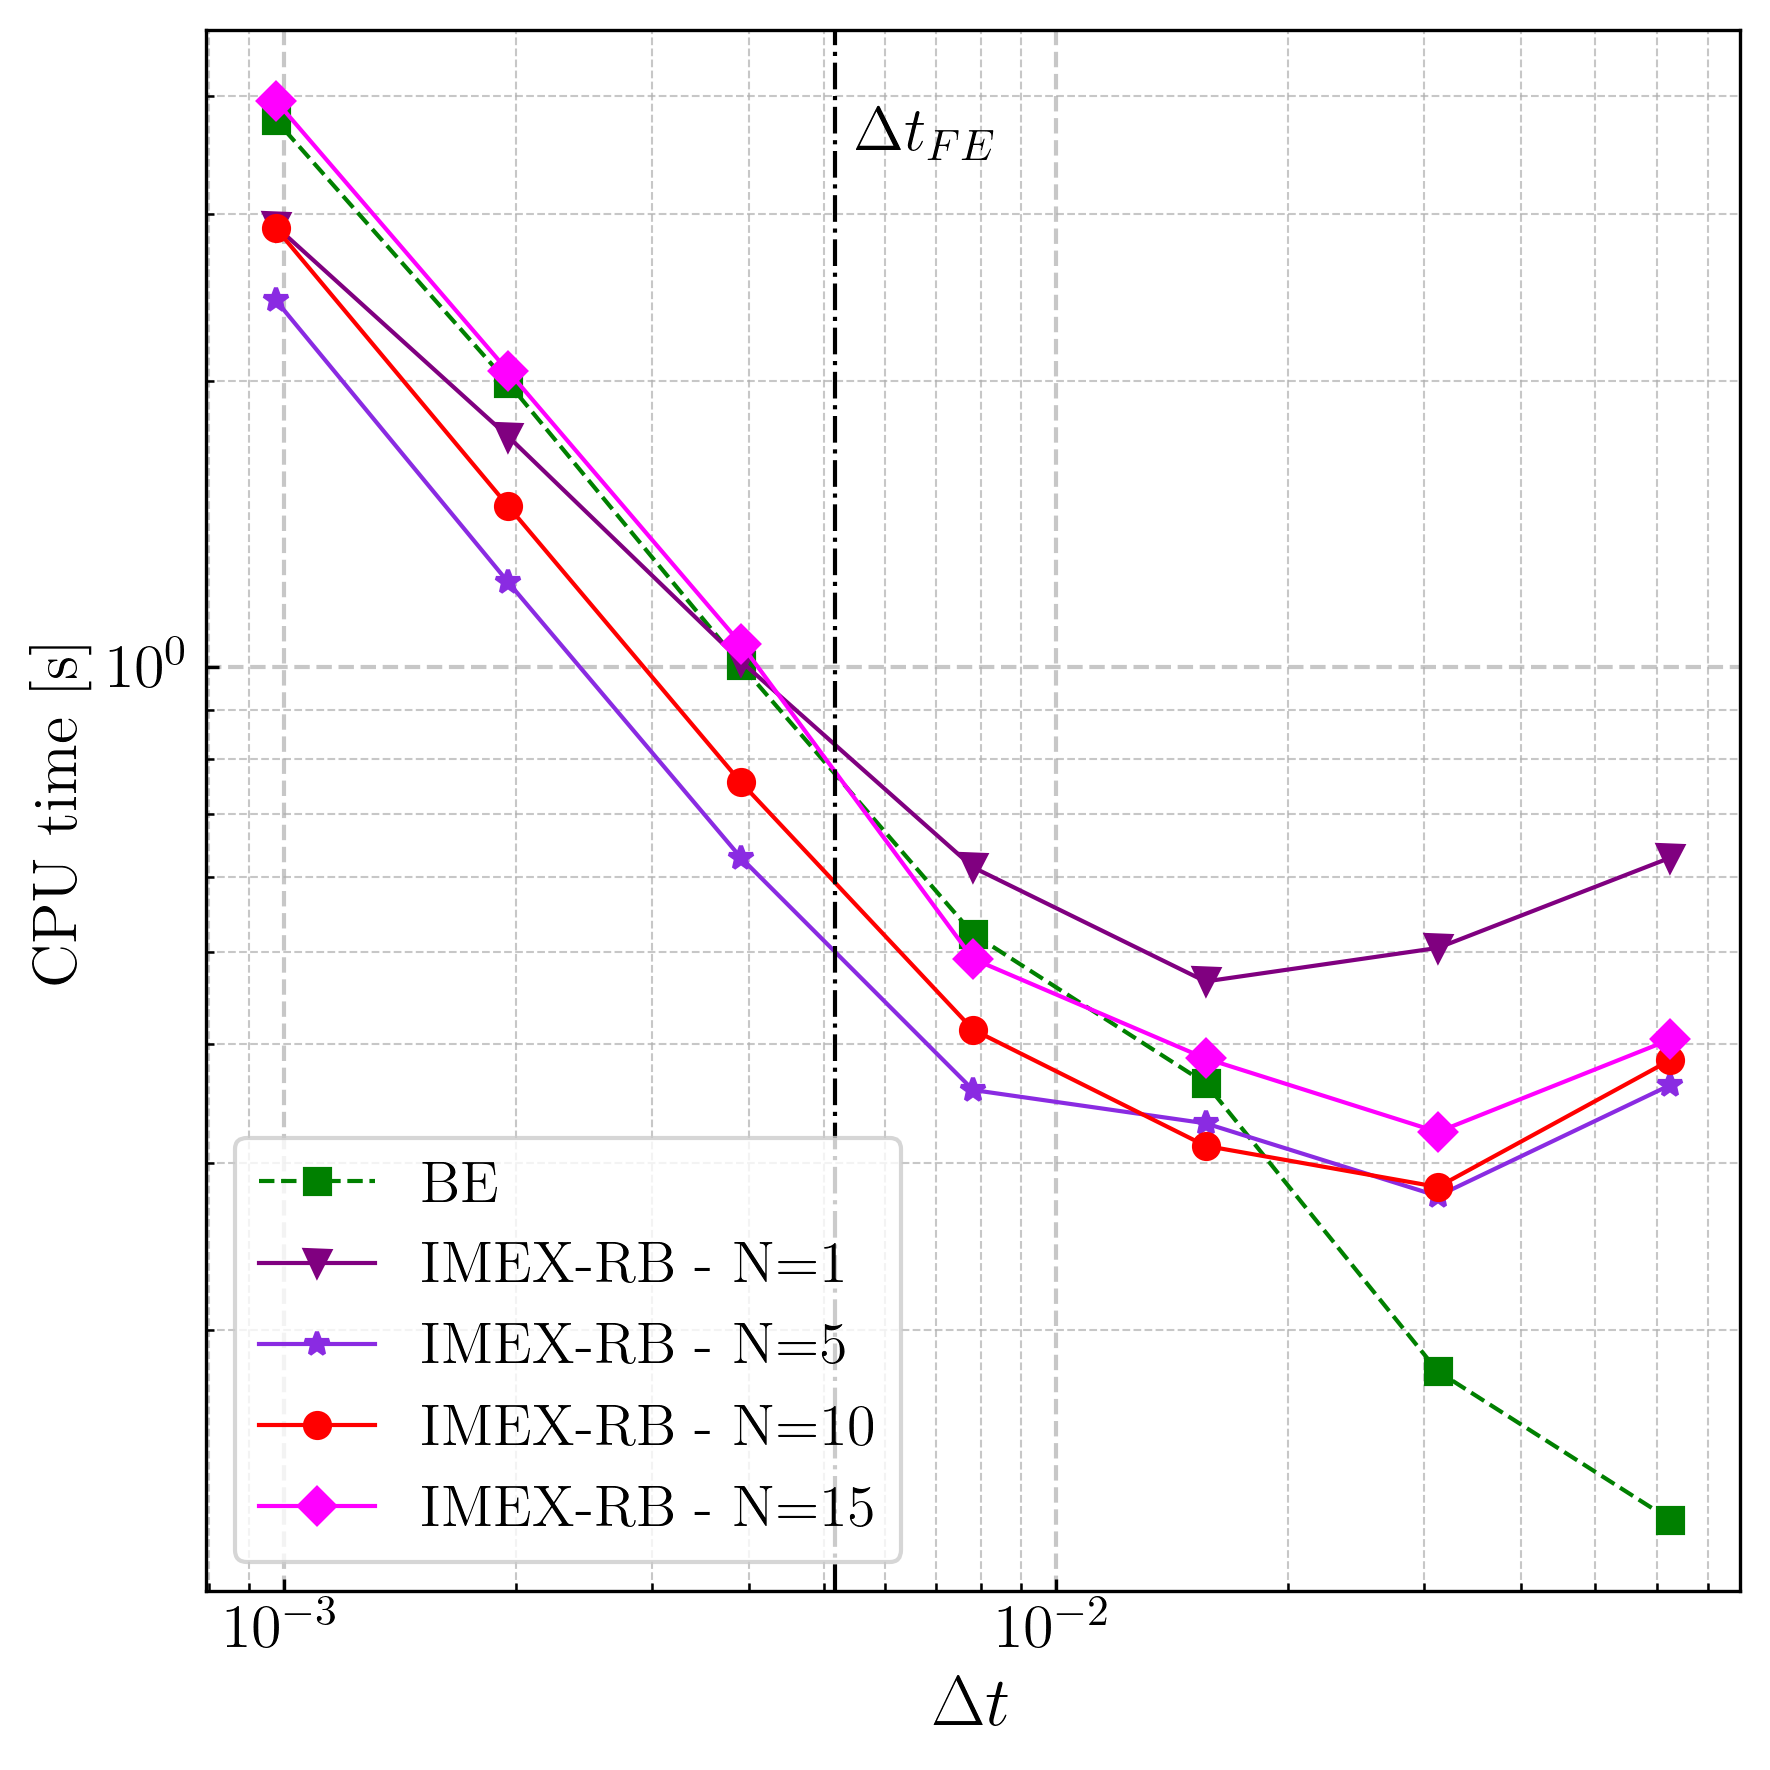

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(1 / Nts, timesBE, '--s', markersize=6, color="green", 
           label="BE")

ax.loglog(1 / Nts, timesIMEX[:, 0], '-v', markersize=6, color="purple", 
           label=f"IMEX-RB - N={Ns[0]}")
ax.loglog(1 / Nts, timesIMEX[:, 1], '-*', markersize=6, color="blueviolet", 
           label=f"IMEX-RB - N={Ns[1]}")
ax.loglog(1 / Nts, timesIMEX[:, 2], '-o', markersize=6, color="red", 
           label=f"IMEX-RB - N={Ns[2]}")
ax.loglog(1 / Nts, timesIMEX[:, 3], '-D', markersize=6, color="magenta", 
           label=f"IMEX-RB - N={Ns[3]}")
#ax.loglog(1 / Nts, timesIMEX[:, 4], '-X', markersize=6, color="red", 
#           label=f"IMEX-RB - N={Ns[4]}")

ax.axvline(1 / Nt_FE, color="k", linestyle='-.') 
ax.text(5.5e-3, 3.5, r"$\Delta t_{FE}$", fontsize=15, color='k')

ax.legend(fontsize=14, loc="lower left")
ax.grid(which="major", linestyle='--', linewidth=1)
ax.grid(which="minor", linestyle='--', linewidth=.5)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("CPU time [s]", fontsize=15)

#ax.set_ylim([1e-1, None])

plt.tight_layout()

plt.savefig(f'times_N_Nh_{Nh}.png', dpi=400)